# Data Exploration

---

## Import packages

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns

import pathlib

---

## Setup Folders
As always we start with specifying the data paths:

In [35]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'switchdrive', 'Biozentrum', 'Andreas')

processed_dir = proj_dir / 'processed'
data_dir = proj_dir / 'output'

---

## Load Data
We load the data from the last notebook;

In [36]:
#load data frame
df_name = data_dir / 'caulobacter_combined_data.csv'
df = pd.read_csv(df_name, index_col=0)

#add unique id of cell by combining strain and replicate
df['uni_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_cell'].map(str)
df['uni_par_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_par'].map(str)
df.head()


,id_seg,id_cell,id_par,id_colony,id_d1,id_d2,id_sib,frames,new_pole,old_pole,...,fluo2,x_pos,y_pos,generation,age,strain,movie_name,replicate,uni_id,uni_par_id
0,0,0,-1,0,-1,-1,-1,0,[ 4 706],[ 2 706],...,411.577778,705.777778,2.955556,0.0,0,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0,AKS1088-0--1
1,0,0,-1,0,-1,-1,-1,1,[ 4 700],[ 3 700],...,400.348837,700.255814,2.813953,0.0,1,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0,AKS1088-0--1
2,0,0,-1,0,-1,-1,-1,2,[ 3 705],[ 0 699],...,372.648649,702.243243,2.405405,0.0,2,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0,AKS1088-0--1
3,0,0,-1,0,-1,-1,-1,3,[ 2 704],[ 2 703],...,371.757576,703.606061,2.242424,0.0,3,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0,AKS1088-0--1
4,0,0,-1,0,-1,-1,-1,4,[ 3 704],[ 2 704],...,368.166667,704.047619,2.642857,0.0,4,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0,AKS1088-0--1


Text(0.5, 0, 'life time of cell [frames]')

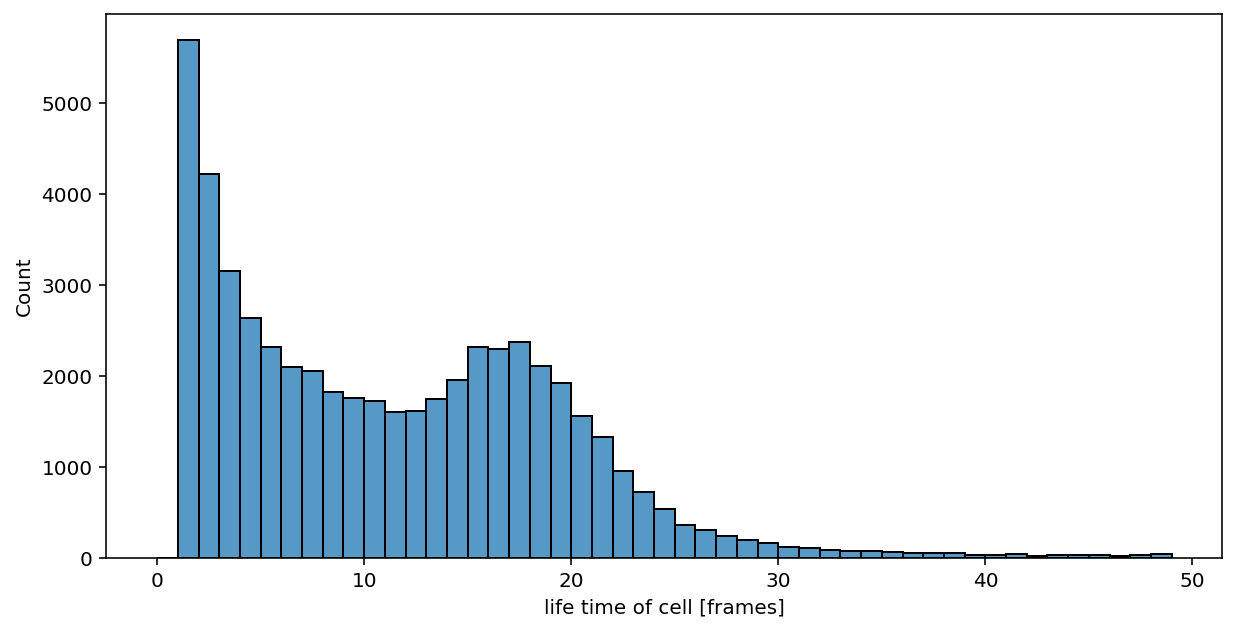

In [37]:
#plot life time of cells
ax = sns.histplot(data=df.groupby('uni_id').size(), bins=np.arange(50))
ax.set_xlabel('life time of cell [frames]')

---

## Check data


dropping 295077 measurements, 49.8% remaining


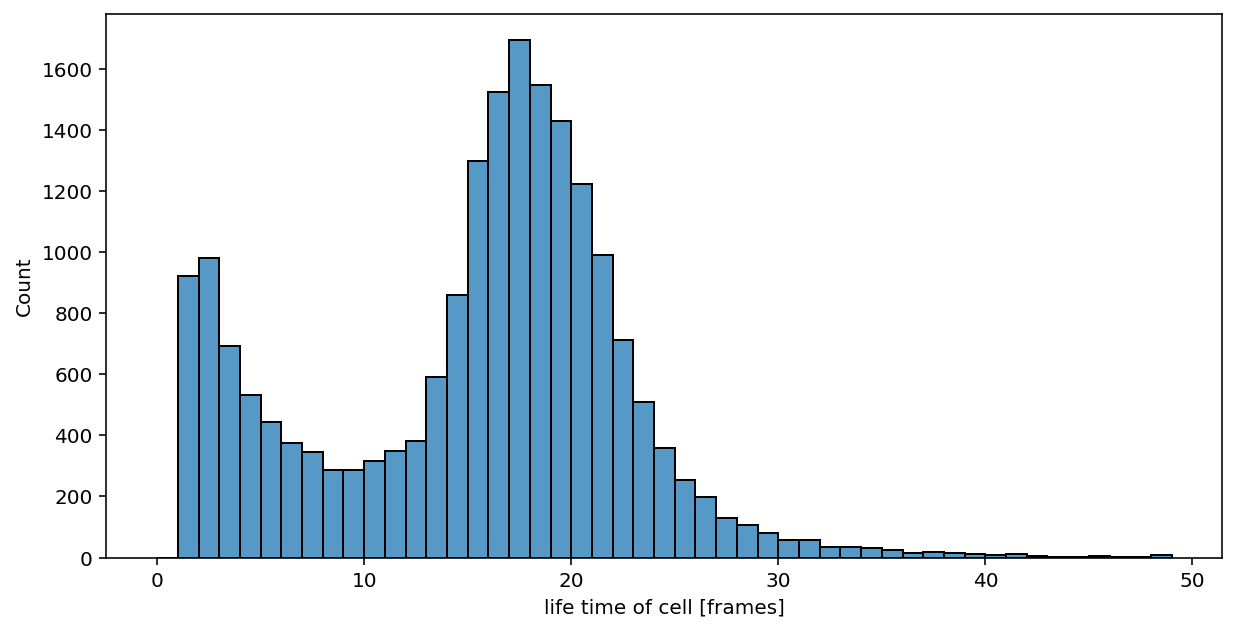

In [38]:
#plot cell life_time for full lineages
has_mom = df["id_par"] > -1
has_d1 = df["id_d1"] > -1
has_d2 = df["id_d2"] > -1
full_lin = has_mom & has_d1 & has_d2

df_compl = df[full_lin].copy()
ax = sns.histplot(data=df_compl.groupby('uni_id').size(), bins=np.arange(50))
ax.set_xlabel('life time of cell [frames]')
print('dropping %i measurements, %.1f%% remaining' % (df.shape[0]-df_compl.shape[0], df_compl.shape[0]/df.shape[0]*100))


---

## Check lineages

<AxesSubplot:xlabel='rel_dl', ylabel='Count'>

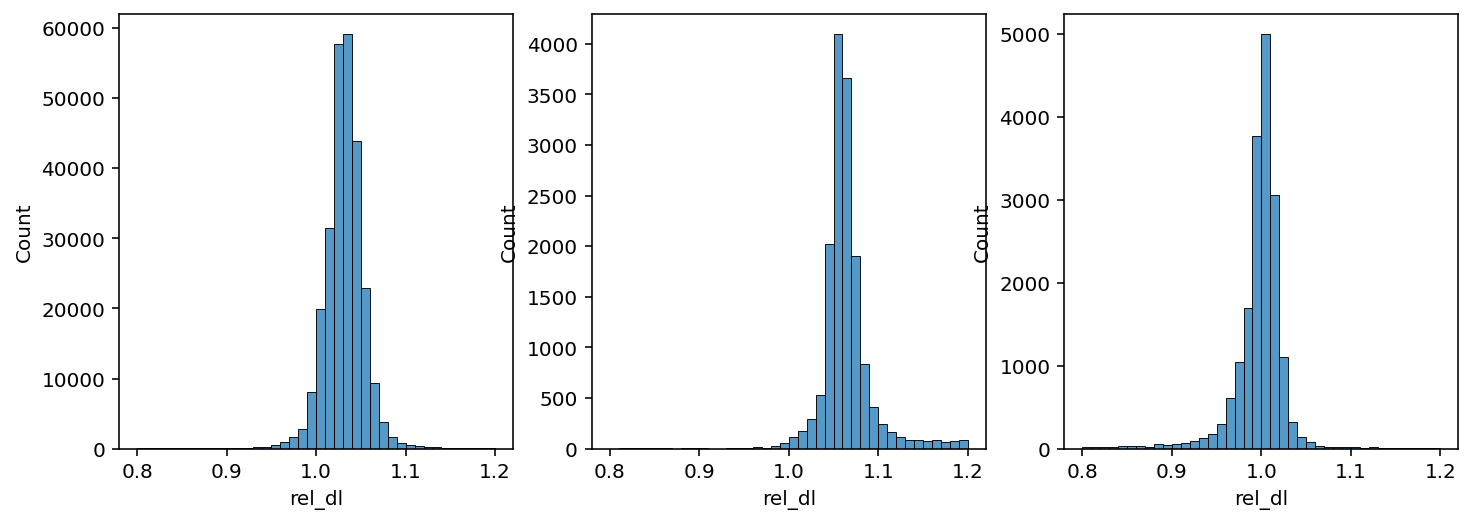

In [39]:
#calc length change
dl = df_compl.groupby('uni_id')['length'].diff()
df_compl['rel_dl'] = (df_compl['length'] + dl)/df_compl['length']
max_dl = df_compl.groupby('uni_id')['rel_dl'].max()
min_dl = df_compl.groupby('uni_id')['rel_dl'].min()

fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.histplot(ax=axs[0], data=df_compl, x='rel_dl', bins=np.linspace(0.8,1.2,41))
sns.histplot(ax=axs[1], data=max_dl, bins=np.linspace(0.8,1.2,41))
sns.histplot(ax=axs[2], data=min_dl, bins=np.linspace(0.8,1.2,41))


In [40]:
#analyze change in length
dl_list = []
movies_grouped = df_compl.groupby('movie_name')

for name, movie in movies_grouped:
    cells_grouped = movie.groupby('uni_id')
    for name, cell in cells_grouped:
        
        try:
            sis_idx = movie['id_cell'] == cell['id_sib'].iloc[0]
            par_idx = movie['id_cell'] == cell['id_par'].iloc[0]
            
            #get length
            len_cel = cell['length'].iloc[0]
            len_sib = movie.loc[sis_idx, 'length'].iloc[0]
            len_par = movie.loc[par_idx, 'length'].iloc[-1]
        
            dl_list.append((len_cel + len_sib) / len_par)
        except:
            continue


<AxesSubplot:ylabel='Count'>

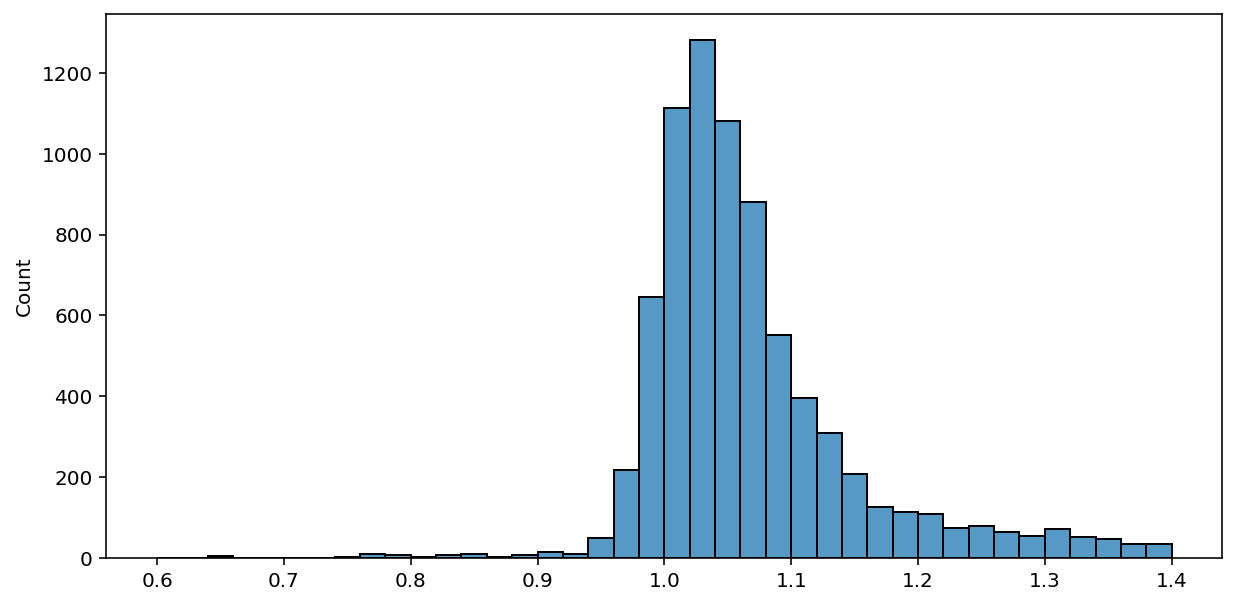

In [41]:
sns.histplot(data=dl_list, bins=np.linspace(0.6,1.4,41))

## Filter data

We use following checks:
 - We only consider lineages that are around for at least 30 minutes (7 frames)
 - We filter out lineages where the length changes too much.
    - We calculate length change as $\frac{l(t+\Delta t)}{l(t)} = 2^{\Delta t / t_d}$
    - We allow for a max increase of 1.08 (e.q. to $t_d=45$  min), and a max decrease of 0.92.
 - We filter out lineages where length changes too much between division $\frac{l_{d1}+l_{d2}}{l_p}$
 - We filter out lineages where we do not have sibling cell

In [42]:
new_df_list = []

#filter lineages
min_num_frm = 7

#window over which to average cdg levels at end of life / -1 is all life 
av_wndw  = -1

# filter on length change during life time
max_dl = 1.08 #(eq. to td=45min)
min_dl = 0.92

# filter on length change during division
max_dl_div = 1.2 
min_dl_div = 0.94

df_list = []
movies_grouped = df.groupby('movie_name')

cols = ['uni_par_id', 'strain', 'movie_name', 'replicate', 'id_colony', 'id_par',
 'frames', 'generation', 'age']

def check_growth(len):
    dl = len[1:] / len[0:-1]
    return np.all(dl>min_dl) & np.all(dl<max_dl)

reason_skipped = []

for name, movie in movies_grouped:
    
    #loop by parent cells
    cells_grouped = movie.groupby('uni_par_id')
    for name, par_cell in cells_grouped:  
        
        #check if full lineage
        has_d1 = par_cell["id_d1"].iloc[0] > -1
        has_d2 = par_cell["id_d2"].iloc[0] > -1
        paired_lin = has_d1 & has_d2
        
        if not paired_lin: reason_skipped.append(1)

        if paired_lin:
            d1_idx = movie['id_cell'] == par_cell["id_d1"].iloc[0]
            d2_idx = movie['id_cell'] == par_cell["id_d2"].iloc[0]
            
            has_d11 = movie.loc[d1_idx, 'id_d1'].iloc[0] > -1
            has_d12 = movie.loc[d1_idx, 'id_d2'].iloc[0] > -1
            has_d21 = movie.loc[d2_idx, 'id_d1'].iloc[0] > -1
            has_d22 = movie.loc[d2_idx, 'id_d2'].iloc[0] > -1
            full_lin = has_d11 & has_d12 & has_d21 & has_d22
            
            if not full_lin: reason_skipped.append(2)

            if full_lin:
                
                #check if there are enough frames
                len_old = movie.loc[d1_idx, 'length']
                len_new = movie.loc[d2_idx, 'length']
                len_ok = (len_old.size >= min_num_frm) & (len_new.size >= min_num_frm) 
                if not len_ok: reason_skipped.append(3)

                if len_ok:
                    #check length across division                         
                    dl = (len_old.iloc[0] + len_new.iloc[0]) / par_cell['length'].iloc[-1]
                    div_ok = (dl > min_dl_div) &  (dl < max_dl_div)
                    if not div_ok: reason_skipped.append(4)
                    
                    if div_ok:
                        #check length of cells 
                        frms = np.arange(min(len_old.size, len_new.size))
                        
                        len_old = len_old.iloc[frms].values 
                        len_new = len_new.iloc[frms].values
                        
                        len1_ok = check_growth(len_old)
                        len2_ok = check_growth(len_new)
                        if not len1_ok: reason_skipped.append(5)
                        if not len2_ok: reason_skipped.append(6)

                        if len1_ok & len2_ok:
                            #cell pair ok, process
                            id_old = par_cell["id_d1"].iloc[0]
                            id_new = par_cell["id_d2"].iloc[0]
                            
                            #copy data frame   
                            cell = movie.loc[d1_idx, :]
                            new_df = cell.iloc[frms, df.columns.get_indexer(cols)].reset_index(drop=True)
                            
                            #get fluorescent values
                            fluo_old = cell['fluo1'].iloc[frms].values 
                            fluo_new = movie.loc[d2_idx, 'fluo1'].iloc[frms].values 

                            #calc fluorescence ratio
                            rel_fluor = fluo_old / fluo_new
                            av_frms = min(av_wndw, rel_fluor.size)
                            fluo_ratio = rel_fluor.mean() if av_frms==-1 else rel_fluor[-av_frms:].mean()
                            
                            #order d1 and d2 based on cdg levels
                            old_is_high = True if fluo_ratio>1 else False
                            
                            #normalize fluor
                            max_fluor = fluo_old[0] if fluo_ratio>1 else fluo_new[0]
                            fluo_old_norm = fluo_old / max_fluor
                            fluo_new_norm = fluo_new / max_fluor
                            
                            #d1 should be old pole
                            new_df['high_in_old'] = 1 if old_is_high else 0
                            
                            #add new fields to df
                            new_df['cdg_old'] =  fluo_old 
                            new_df['cdg_new'] =  fluo_new 
                            
                            new_df['cdg_norm_old'] =  fluo_old_norm 
                            new_df['cdg_norm_new'] =  fluo_new_norm 
                            
                            new_df['cdg_dh'] =  fluo_old if old_is_high  else fluo_new
                            new_df['cdg_dl'] =  fluo_new if old_is_high  else fluo_old
                                    
                            new_df['cdg_norm_dh'] =  fluo_old_norm if old_is_high  else fluo_new_norm
                            new_df['cdg_norm_dl'] =  fluo_new_norm if old_is_high  else fluo_old_norm
                            
                            new_df['len_dh'] =  len_old if old_is_high  else len_new
                            new_df['len_dl'] =  len_new if old_is_high  else len_old
                            
                            new_df['idc_dh'] =  id_old if old_is_high  else id_new
                            new_df['idc_dl'] =  id_new if old_is_high  else id_old
                            
                            new_df['rel_cdg'] = 1/rel_fluor if old_is_high else rel_fluor
                            
                            new_df_list.append(new_df)
                                    

                 
    
             

<AxesSubplot:ylabel='Count'>

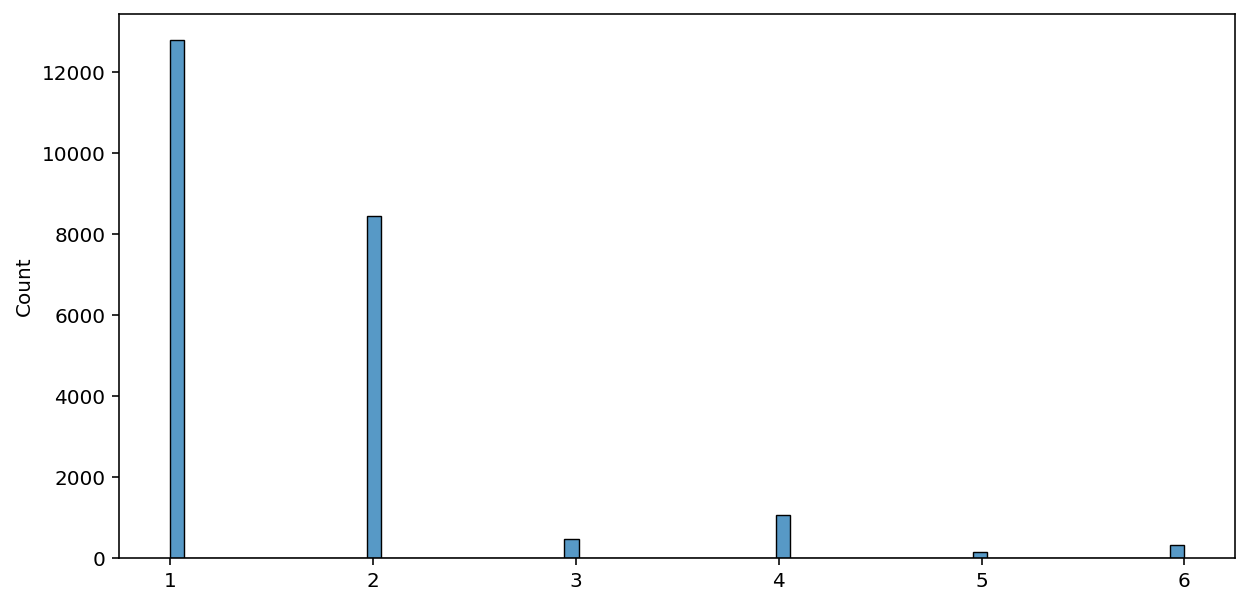

In [43]:
sns.histplot(reason_skipped)

In [44]:
df_paired = pd.concat(new_df_list)

In [45]:
df_paired.head()

,uni_par_id,strain,movie_name,replicate,id_colony,id_par,frames,generation,age,high_in_old,...,cdg_norm_new,cdg_dh,cdg_dl,cdg_norm_dh,cdg_norm_dl,len_dh,len_dl,idc_dh,idc_dl,rel_cdg
0,AKS1088-0-150,AKS1088,AKS1088_TL01_01,0,44,150,36,2.0,0,0,...,1.000000,701.015544,725.633166,1.000000,1.035117,27.000000,29.147118,582,151,1.035117
1,AKS1088-0-150,AKS1088,AKS1088_TL01_01,0,44,150,37,2.0,1,0,...,0.981288,687.898477,716.688995,0.981288,1.022358,27.000000,30.231161,582,151,1.041853
2,AKS1088-0-150,AKS1088,AKS1088_TL01_01,0,44,150,38,2.0,2,0,...,0.971520,681.050761,706.654709,0.971520,1.008044,29.000000,31.609030,582,151,1.037595
3,AKS1088-0-150,AKS1088,AKS1088_TL01_01,0,44,150,39,2.0,3,0,...,0.970534,680.359223,708.488987,0.970534,1.010661,31.000000,32.991478,582,151,1.041345
4,AKS1088-0-150,AKS1088,AKS1088_TL01_01,0,44,150,40,2.0,4,0,...,0.962008,674.382883,706.727660,0.962008,1.008148,32.008327,33.569576,582,151,1.047962


<AxesSubplot:xlabel='strain'>

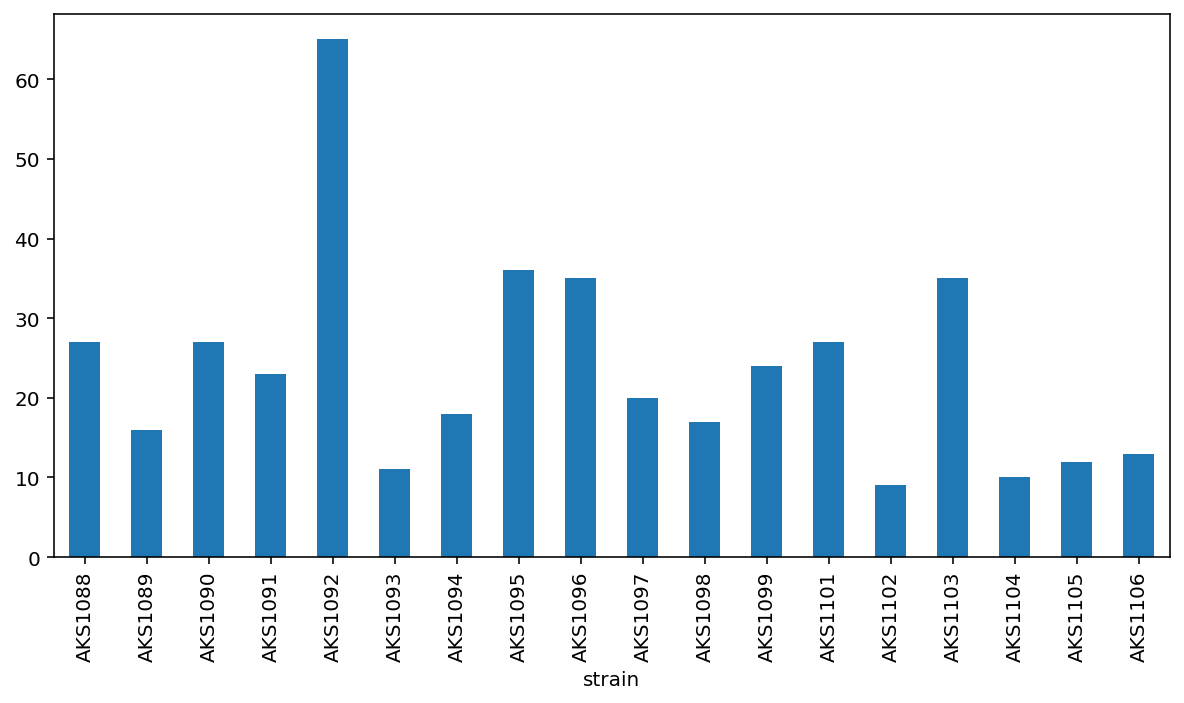

In [46]:
first_frame = df_paired.groupby('uni_par_id').first()
num_lin_per_strain = first_frame.groupby('strain').size() 
num_lin_per_strain.head(n=18)
num_lin_per_strain.plot(kind='bar')


In [47]:
num_lin_per_strain

strain
AKS1088    27
AKS1089    16
AKS1090    27
AKS1091    23
AKS1092    65
AKS1093    11
AKS1094    18
AKS1095    36
AKS1096    35
AKS1097    20
AKS1098    17
AKS1099    24
AKS1101    27
AKS1102     9
AKS1103    35
AKS1104    10
AKS1105    12
AKS1106    13
dtype: int64

## Save paired data

In [48]:
out_name = processed_dir / 'caulobacter_combined_filtered_paired_data_full_lin.csv'
df_paired.to_csv(out_name)

---

## Alternative filtering

In [64]:
new_df_list = []

#filter lineages
min_num_frm = 12

#window over which to average cdg levels at end of life / -1 is all life 
av_wndw  = -1

# filter on length change during life time
max_dl = 1.08 #(eq. to td=45min)
min_dl = 0.92

# filter on length change during division
max_dl_div = 1.2 
min_dl_div = 0.94

df_list = []
movies_grouped = df.groupby('movie_name')

cols = ['uni_par_id', 'strain', 'movie_name', 'replicate', 'id_colony', 'id_par',
 'frames', 'generation', 'age']

def check_growth(len):
    dl = len[1:] / len[0:-1]
    return np.all(dl>min_dl) & np.all(dl<max_dl)

reason_skipped = []

for name, movie in movies_grouped:
    
    #loop by parent cells
    cells_grouped = movie.groupby('uni_par_id')
    for name, par_cell in cells_grouped:  
        
        #check if full lineage
        has_d1 = par_cell["id_d1"].iloc[0] > -1
        has_d2 = par_cell["id_d2"].iloc[0] > -1
        paired_lin = has_d1 & has_d2
        
        
        if not paired_lin: reason_skipped.append(1)

        if paired_lin:
            d1_idx = movie['id_cell'] == par_cell["id_d1"].iloc[0]
            d2_idx = movie['id_cell'] == par_cell["id_d2"].iloc[0]
            
            # has_d11 = movie.loc[d1_idx, 'id_d1'].iloc[0] > -1
            # has_d12 = movie.loc[d1_idx, 'id_d2'].iloc[0] > -1
            # has_d21 = movie.loc[d2_idx, 'id_d1'].iloc[0] > -1
            # has_d22 = movie.loc[d2_idx, 'id_d2'].iloc[0] > -1
            
            # full_lin = has_d11 & has_d12 & has_d21 & has_d22
            full_lin = True

            if not full_lin: reason_skipped.append(2)

            if full_lin:
                
                #check if there are enough frames
                len_old = movie.loc[d1_idx, 'length']
                len_new = movie.loc[d2_idx, 'length']
                len_ok = (len_old.size >= min_num_frm) & (len_new.size >= min_num_frm) 
                if not len_ok: reason_skipped.append(3)

                if len_ok:
                    #check length across division                         
                    dl = (len_old.iloc[0] + len_new.iloc[0]) / par_cell['length'].iloc[-1]
                    div_ok = (dl > min_dl_div) &  (dl < max_dl_div)
                    if not div_ok: reason_skipped.append(4)
                    
                    if div_ok:
                        #check length of cells 
                        frms = np.arange(min(len_old.size, len_new.size))
                        
                        len_old = len_old.iloc[frms].values 
                        len_new = len_new.iloc[frms].values
                        
                        len1_ok = check_growth(len_old)
                        len2_ok = check_growth(len_new)
                        if not len1_ok: reason_skipped.append(5)
                        if not len2_ok: reason_skipped.append(6)

                        if len1_ok & len2_ok:
                            #cell pair ok, process
                            id_old = par_cell["id_d1"].iloc[0]
                            id_new = par_cell["id_d2"].iloc[0]
                            
                            #copy data frame   
                            cell = movie.loc[d1_idx, :]
                            new_df = cell.iloc[frms, df.columns.get_indexer(cols)].reset_index(drop=True)
                            
                            #get fluorescent values
                            fluo_old = cell['fluo1'].iloc[frms].values 
                            fluo_new = movie.loc[d2_idx, 'fluo1'].iloc[frms].values 

                            #calc fluorescence ratio
                            rel_fluor = fluo_old / fluo_new
                            av_frms = min(av_wndw, rel_fluor.size)
                            fluo_ratio = rel_fluor.mean() if av_frms==-1 else rel_fluor[-av_frms:].mean()
                            
                            #order d1 and d2 based on cdg levels
                            old_is_high = True if fluo_ratio>1 else False
                            
                            #normalize fluor
                            max_fluor = fluo_old[0] if fluo_ratio>1 else fluo_new[0]
                            fluo_old_norm = fluo_old / max_fluor
                            fluo_new_norm = fluo_new / max_fluor
                            
                            #d1 should be old pole
                            new_df['high_in_old'] = 1 if old_is_high else 0
                            
                            #add new fields to df
                            new_df['cdg_old'] =  fluo_old 
                            new_df['cdg_new'] =  fluo_new 
                            
                            new_df['cdg_norm_old'] =  fluo_old /  fluo_old[0]
                            new_df['cdg_norm_new'] =  fluo_new /  fluo_old[0]
                            
                            new_df['cdg_dh'] =  fluo_old if old_is_high  else fluo_new
                            new_df['cdg_dl'] =  fluo_new if old_is_high  else fluo_old
                                    
                            new_df['cdg_norm_dh'] =  fluo_old_norm if old_is_high  else fluo_new_norm
                            new_df['cdg_norm_dl'] =  fluo_new_norm if old_is_high  else fluo_old_norm
                            
                            new_df['len_dh'] =  len_old if old_is_high  else len_new
                            new_df['len_dl'] =  len_new if old_is_high  else len_old
                            
                            new_df['idc_dh'] =  id_old if old_is_high  else id_new
                            new_df['idc_dl'] =  id_new if old_is_high  else id_old
                            
                            new_df['rel_cdg_hl'] = 1/rel_fluor if old_is_high else rel_fluor
                            new_df['rel_cdg_no'] = fluo_new / fluo_old

                            new_df_list.append(new_df)
                                    

                 
    
             

<AxesSubplot:ylabel='Count'>

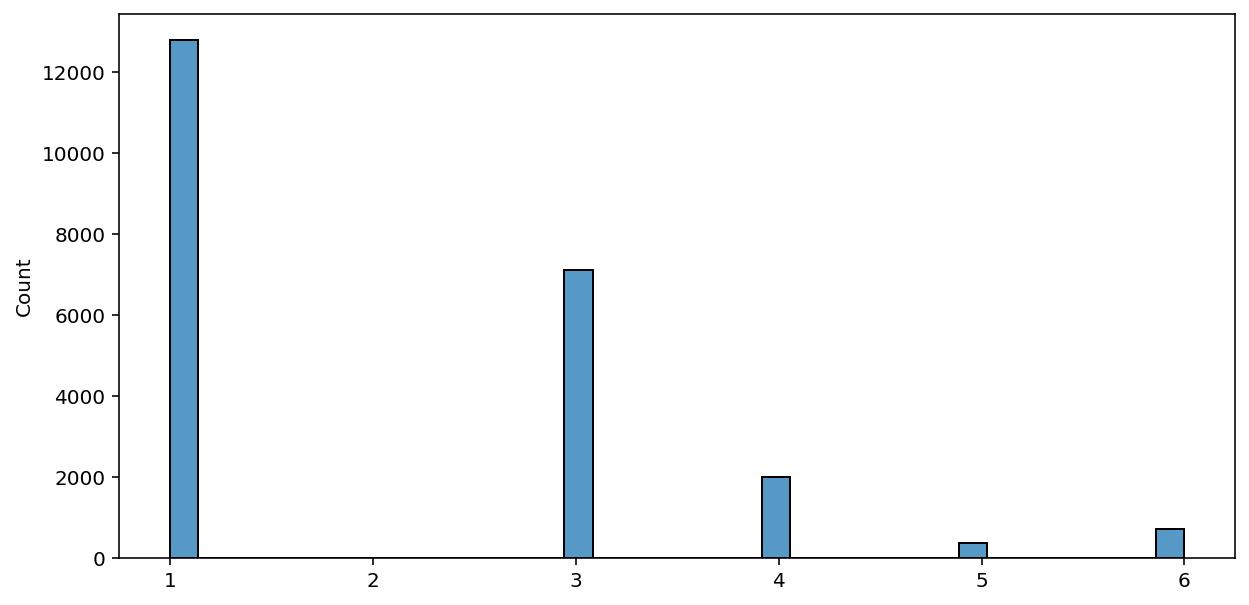

In [60]:
sns.histplot(reason_skipped)

In [61]:
df_paired2 = pd.concat(new_df_list)

<AxesSubplot:xlabel='strain'>

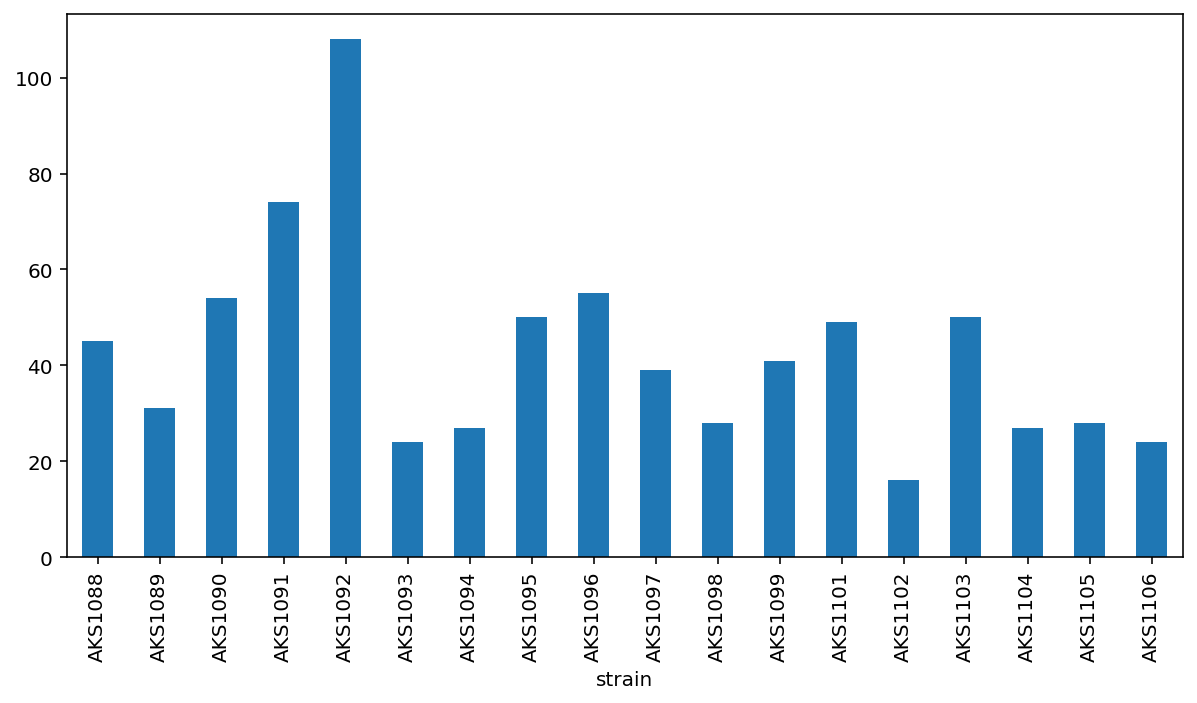

In [62]:
first_frame = df_paired2.groupby('uni_par_id').first()
num_lin_per_strain = first_frame.groupby('strain').size() 
num_lin_per_strain.head(n=18)
num_lin_per_strain.plot(kind='bar')


In [57]:
num_lin_per_strain

strain
AKS1088     45
AKS1089     31
AKS1090     54
AKS1091     74
AKS1092    108
AKS1093     24
AKS1094     27
AKS1095     50
AKS1096     55
AKS1097     39
AKS1098     28
AKS1099     41
AKS1101     49
AKS1102     16
AKS1103     50
AKS1104     27
AKS1105     28
AKS1106     24
dtype: int64

## Save paired data

In [63]:
out_name = processed_dir / 'caulobacter_combined_filtered_paired_data_60min.csv'
df_paired2.to_csv(out_name)